# CS 5 - Spring 2024 - Final Project

**Project Title**: Determining if Unequal Teams make Better or Worse Teams

**Project Member(s)**: Colin Rodriguez

## Introduction

Use this space to introduce your final project. Explain the motivation for working on this particular topic. Give a preview of the ML paradigm(s) and algorithms you will be using.

## Imports

Use the code cell below to import any Python libraries your project requires. Beside each `import` statement, write a comment that explains why that particular library is needed.

In [1]:
# The three classifiers which we will use for our ML-Algorithms. Additionally,
# MLPClassifier stands for Multi-layer Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier

# Numpy is required for sklearn, and also implements an easy method to grab data from csv files.
import numpy as np
# Matplotlib allows us to graph our findings
import matplotlib.pyplot as plt

# Allow us to create a folder for our data.
import os
# Python module for writing csv files.
import csv

## Domain

Explain the domain you have chosen for your project. If you're using an external dataset, cite where you got it from. Explain the format of the data. How are you going to import the dataset into this notebook? If you're generating your own dataset, how are you going to do that? What, if any, preprocessing do you need to do on your dataset? What, if any, assumptions are being made by the dataset?

Use the code cell below to import or generate your dataset, along with any preprocessing.

Obtaining the data was a very long process. See the file `gathering-data.ipynb`. Our result from that file is stored in `sendouq-data.csv`, but we still need to do some preprocessing.

In [2]:
BATCH_DIRNAME = 'batches'
COLLECTED_DATA_FILENAME = 'sendouq-data.csv'
# IDs so we can separate our data.
SEASON_2_START = 23027
SEASON_3_START = 37626

if not os.path.exists(BATCH_DIRNAME):
    print(rf"Path .\{BATCH_DIRNAME} not found!")
    os.makedirs(BATCH_DIRNAME)
    print("Directory created!")
else:
    print(rf"Found .\{BATCH_DIRNAME}")

# take in an input and output file path. Operator should take in a csv line and 
# transform it into the desired output. Operator should return a 2D list containing
# lines of the CSV file, which are the inner lists
def make_batch(input_batch: str, output_batch: str, operator, skip_first: bool = False) -> None:
    with open(input_batch, 'r', encoding='utf-8', newline='') as infile, \
            open(output_batch, 'w', encoding='utf-8', newline='') as outfile:
        
        if skip_first:
            infile.readline()   # discard the first line if we're reading from our main collected data.

        reader = csv.reader(infile, quoting=csv.QUOTE_MINIMAL, doublequote=False, escapechar='\\')
        writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL, doublequote=False, escapechar='\\')
        for line in reader:
            data = operator(line)
            if data:
                writer.writerows(data)
    print(f"Wrote batch: '{output_batch}'")

# preprocessing step on our data. The data collected has a significant bias towards
# the bravo team (the wins are a 45-55% split). Thus, one trick we can use is to
# mirror each match so that alpha and bravo wins are equal.
def mirror_matches(data: list[str]) -> list[list[str]]:
    out = [data]
    alpha = data[1:5]
    bravo = data[5:9]
    winner = [1 - int(data[9])]
    mirror = [data[0]] + bravo + alpha + winner
    out.append(mirror)
    return out

# make batch of all the data unchanged
make_batch(COLLECTED_DATA_FILENAME, f'{BATCH_DIRNAME}\\all.csv', lambda x : [x], True)

# separate data by seasons
make_batch(f'{BATCH_DIRNAME}\\all.csv', f'{BATCH_DIRNAME}\\season_1.csv',
           lambda x : [x] if int(x[0]) < SEASON_2_START else [])
make_batch(f'{BATCH_DIRNAME}\\all.csv', f'{BATCH_DIRNAME}\\season_2.csv',
           lambda x : [x] if SEASON_2_START <= int(x[0]) < SEASON_3_START else [])
make_batch(f'{BATCH_DIRNAME}\\all.csv', f'{BATCH_DIRNAME}\\season_3.csv',
           lambda x : [x] if SEASON_3_START <= int(x[0]) else [])

# do mirror preprocessing step on all of our data
batches_to_mirror = ['all', 'season_1', 'season_2', 'season_3']
for batch in batches_to_mirror:
    make_batch(f'{BATCH_DIRNAME}\\{batch}.csv',
                     f'{BATCH_DIRNAME}\\{batch}_m.csv', mirror_matches)

Found .\batches
Wrote batch: 'batches\all.csv'
Wrote batch: 'batches\season_1.csv'
Wrote batch: 'batches\season_2.csv'
Wrote batch: 'batches\season_3.csv'
Wrote batch: 'batches\all_m.csv'
Wrote batch: 'batches\season_1_m.csv'
Wrote batch: 'batches\season_2_m.csv'
Wrote batch: 'batches\season_3_m.csv'


In [3]:
# utility function for easily reading the batch data into numpy arrays
def get_batch(batch: str) -> tuple[np.array, np.array]:
    X = np.loadtxt(f'{BATCH_DIRNAME}\\{batch}.csv', delimiter=',', usecols=(1,2,3,4,5,6,7,8))
    y = np.loadtxt(f'{BATCH_DIRNAME}\\{batch}.csv', delimiter=',', usecols=(9))
    return X, y

## ML Algorithm \#1: Logistic Regression

Explain the first ML algorithm you are using for your project. Why did you choose this algorithm? What assumptions does this algorithm make? What kinds of adjustments are you making (e.g., hyperparameters) to the algorithm?

Use the code cell below to apply your machine learning algorithm to the dataset.

In [4]:
# fit our classifiers using Logistic Regression
batches = ['all_m', 'season_1_m', 'season_2_m', 'season_3_m']
classifiers = []
for batch in batches:
    X, y = get_batch(batch)
    classifiers.append(LogisticRegression(penalty='l2',solver='liblinear', max_iter=1000).fit(X, y))

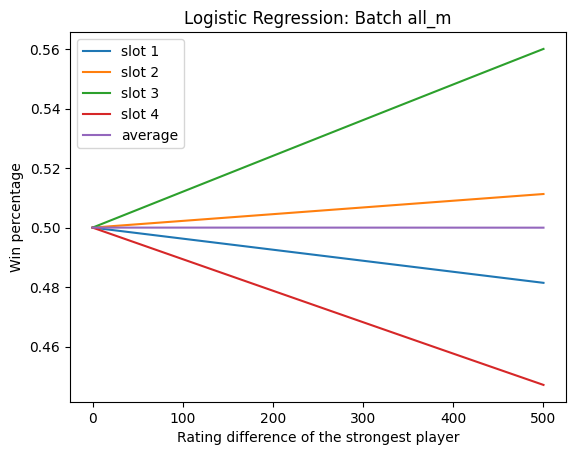

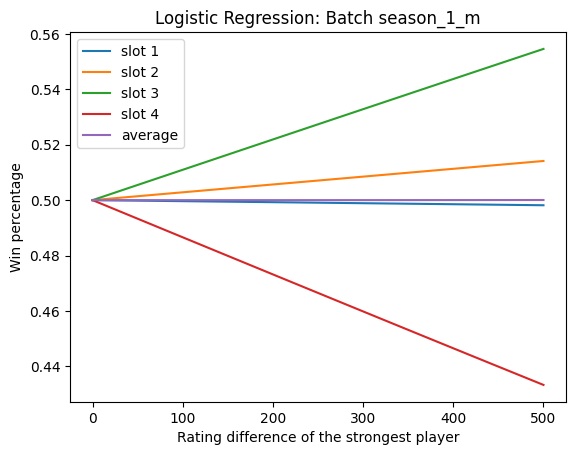

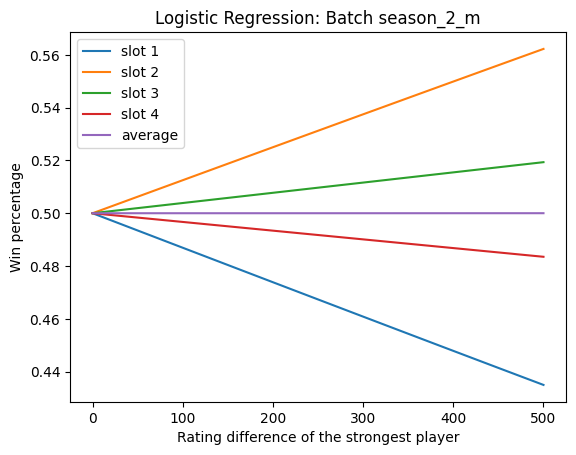

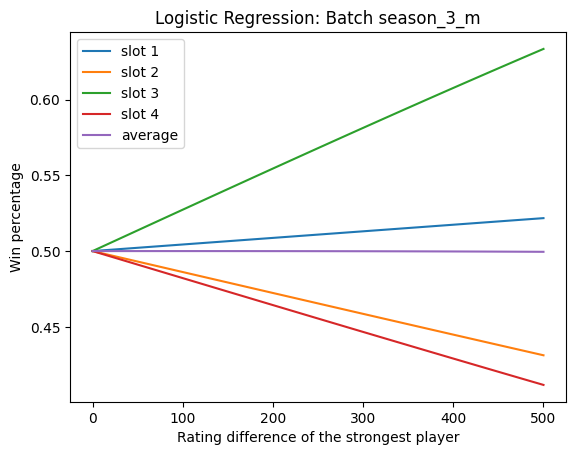

In [5]:
# this function returns an anonymous function to help us create teams where
# one player is acting as the carry for the team. Since there is bias depending
# on which team slot the carry ends up in, we can specify that as a value
# between 0 and 3
def carry_player(slot):
    def func(x):
        r = x/3
        return [1500-r] * slot + [1500+x] + [1500-r] * (3 - slot) + [1500] * 4
    return func

def graph_slots(batches, classifiers, func_builder, xlabel):
    x = np.linspace(0, 500, 100)
    for i, clf in enumerate(classifiers):

        fig, ax = plt.subplots()
        avg_y = np.zeros(len(x))
        for j in range(4):
            func = func_builder(j)
            plot_y = clf.predict_proba([func(v) for v in x])[:, 0]
            ax.plot(x, plot_y, label=f"slot {j+1}")
            avg_y += plot_y
        avg_y /= 4
        ax.plot(x, avg_y, label='average')

        ax.set(xlabel=xlabel, ylabel='Win percentage',
               title=f'Logistic Regression: Batch {batches[i]}')
        ax.legend()
        plt.show()

graph_slots(batches, classifiers, carry_player, 'Rating difference of the strongest player')

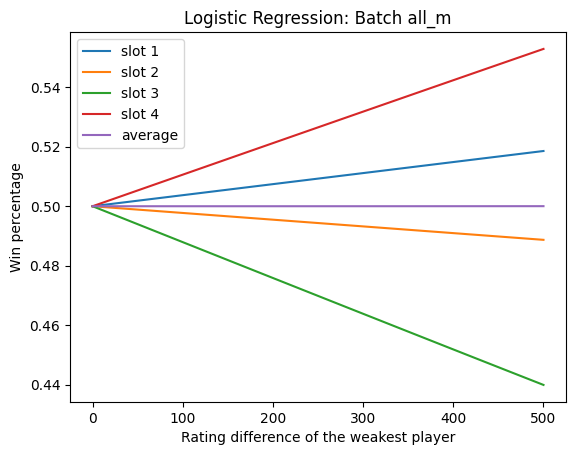

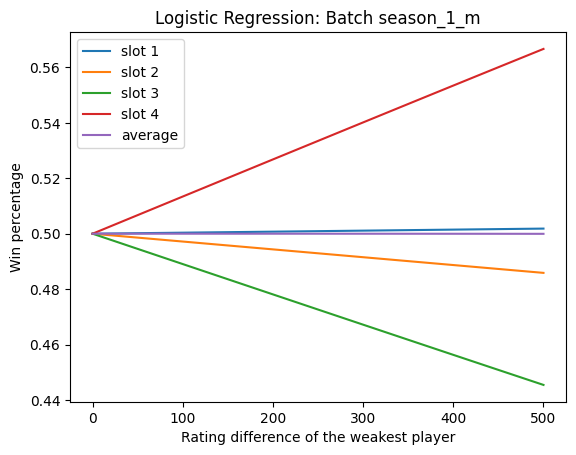

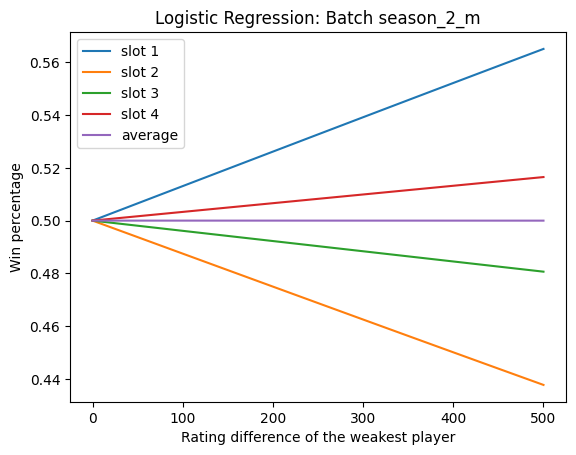

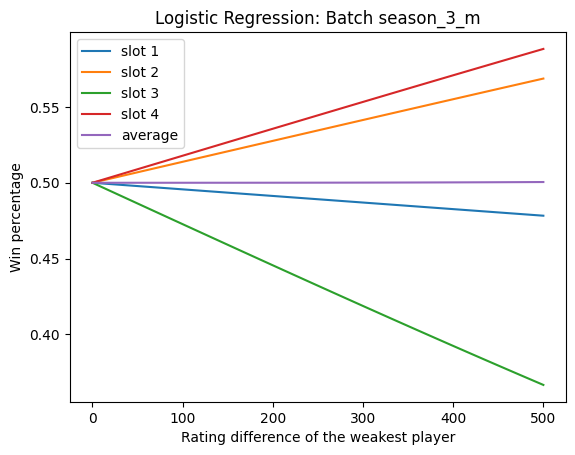

In [6]:
# same as above but lets test a player who's being carried
def carried_player(slot):
    def func(x):
        r = x/3
        return [1500+r] * slot + [1500-x] + [1500+r] * (3 - slot) + [1500] * 4
    return func

graph_slots(batches, classifiers, carried_player, 'Rating difference of the weakest player')

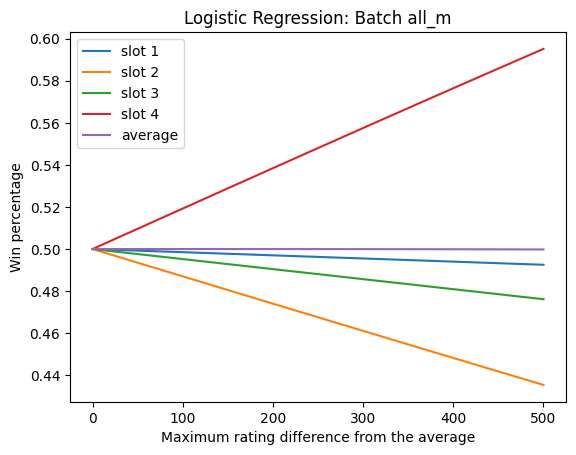

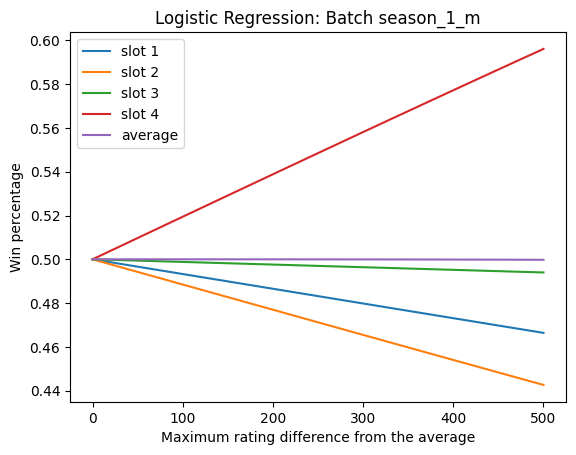

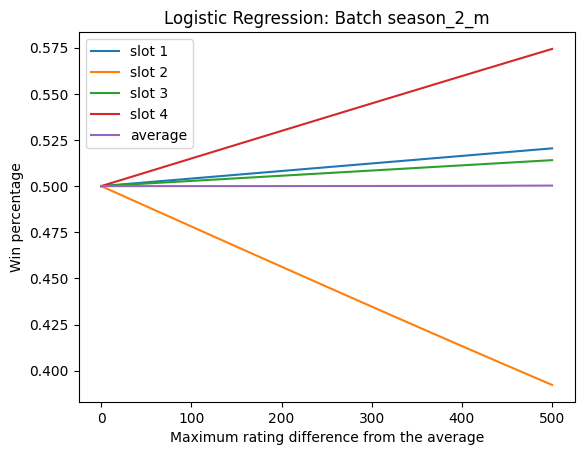

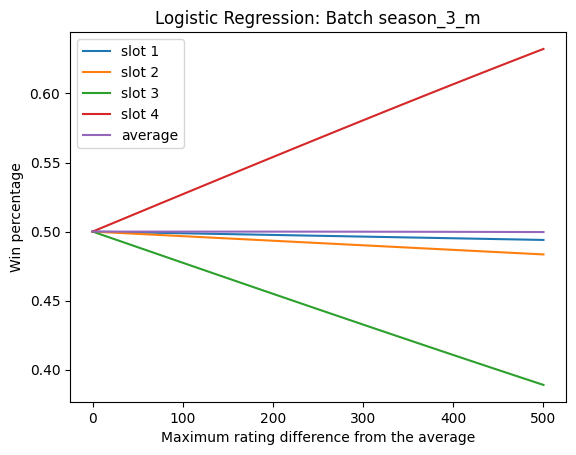

In [7]:
# same as above but lets test a player who's being carried
def equal_spread(slot):
    def func(x):
        r = x/2
        out = []
        if slot == 0:
            out += [1500-x] + [1500-r] + [1500+r] + [1500+x]
        elif slot == 1:
            out += [1500+x] + [1500-x] + [1500-r] + [1500+r]
        elif slot == 2:
            out += [1500+r] + [1500+x] + [1500-x] + [1500-r]
        else:
            out += [1500-r] + [1500+r] + [1500+x] + [1500-x]
            
        return out + [1500] * 4
    return func

graph_slots(batches, classifiers, equal_spread, 'Maximum rating difference from the average')

It seems no matter what we do, as long as the teams fighting have the same average rating, they will have an equal chance to win against each other.

## ML Algorithm \#2: SVN

Explain the second ML algorithm you are using for your project. Why did you choose this algorithm? What assumptions does this algorithm make? What kinds of adjustments are you making (e.g., hyperparameters) to the algorithm?

Use the code cell below to apply your machine learning algorithm to the dataset.

In [8]:
X, y = get_batch('all_m')
clf = svm.SVC(kernel='poly', C=0.001, tol=2, degree=3)

# training step (takes much longer than logistic regression)
clf.fit(X, y)

print(f'Score: {clf.score(X, y):.2%}')

Score: 71.69%


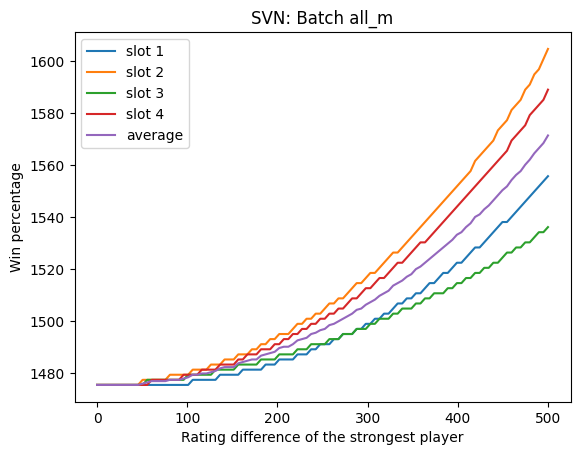

In [9]:
def compare_carry_player(slot):
    def func(x, rd):
        r = x/3
        return [1500-r] * slot + [1500+x] + [1500-r] * (3 - slot) + [rd] * 4
    return func

def graph_slots_compare(func_builder, xlabel):
    fig, ax = plt.subplots()

    x = np.linspace(0, 500, 100)
    y_avg = np.zeros(len(x))
    for i in range(4):
        y = np.zeros(len(x))
        func = func_builder(i)
        for j, x_val in enumerate(x):
            L, R = 500.0, 2500.0
            while L <= R:
                m = (L + R) / 2
                alpha_win = clf.predict([func(x_val, m)])[0] == 0
                if alpha_win:
                    L = m + 1
                else:
                    R = m - 1
            y[j] = R

        ax.plot(x, y, label=f'slot {i+1}')
        y_avg += y

    y_avg /= 4
    ax.plot(x, y_avg, label=f'average')
    ax.set(xlabel=xlabel, ylabel='Win percentage',
               title=f'SVN: Batch all_m')
    ax.legend()
    plt.show()

graph_slots_compare(compare_carry_player, 'Rating difference of the strongest player')


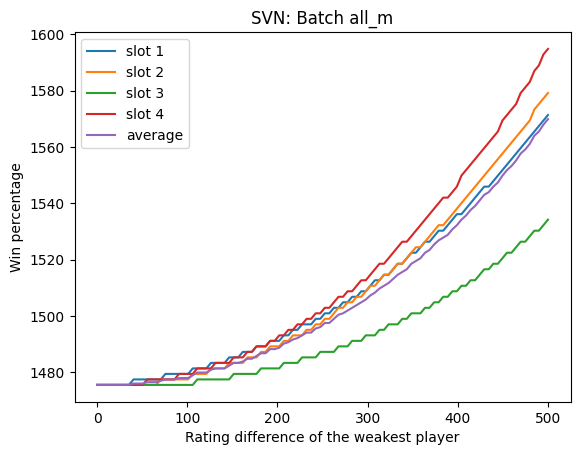

In [10]:
# same as above but lets test a player who's being carried
def compare_carried_player(slot):
    def func(x, rd):
        r = x/3
        return [1500+r] * slot + [1500-x] + [1500+r] * (3 - slot) + [rd] * 4
    return func

graph_slots_compare(compare_carried_player, 'Rating difference of the weakest player')

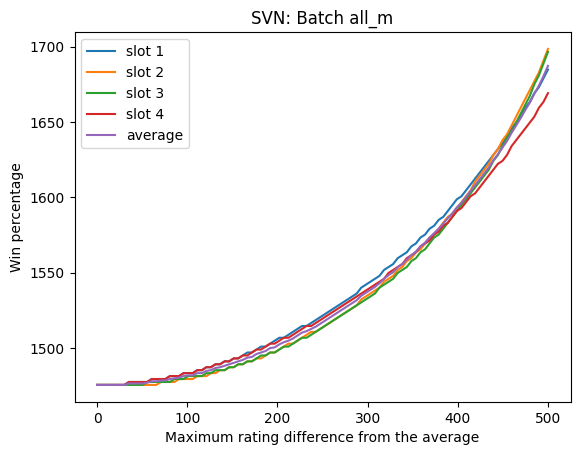

In [11]:
# same as above but lets test a player who's being carried
def compare_equal_spread(slot):
    def func(x, rd):
        r = x/2
        out = []
        if slot == 0:
            out += [1500-x] + [1500-r] + [1500+r] + [1500+x]
        elif slot == 1:
            out += [1500+x] + [1500-x] + [1500-r] + [1500+r]
        elif slot == 2:
            out += [1500+r] + [1500+x] + [1500-x] + [1500-r]
        else:
            out += [1500-r] + [1500+r] + [1500+x] + [1500-x]
            
        return out + [rd] * 4
    return func

graph_slots_compare(compare_equal_spread, 'Maximum rating difference from the average')

SVN wasn't a good choice of an algorithm for this project. By some miracle, we were able to find a margin. However, the margin estimates that as the rating difference between players increases, their effective rating also increases, no matter which players have the larger rating changes. Additionally, the SVN estimates that a balanced match will have bravo winning most of the time, even after our preprocessing step to fix bias. Thus, I wouldn't trust the output of the SVN.

## ML Algorithm \#3: Neural Net

Explain the third ML algorithm you are using for your project. Why did you choose this algorithm? What assumptions does this algorithm make? What kinds of adjustments are you making (e.g., hyperparameters) to the algorithm?

Use the code cell below to apply your machine learning algorithm to the dataset.

In [12]:
# fit our classifiers using a Neural Network
batches = ['all_m', 'season_1_m', 'season_2_m', 'season_3_m']
classifiers = []
for batch in batches:
    X, y = get_batch(batch)
    classifiers.append(MLPClassifier(solver='lbfgs', hidden_layer_sizes=(12, 16), random_state=1, max_iter=1000).fit(X, y))
    print(f'score of {batch}: {classifiers[-1].score(X, y):.2%}')

score of all_m: 71.80%
score of season_1_m: 75.33%
score of season_2_m: 70.26%
score of season_3_m: 69.19%


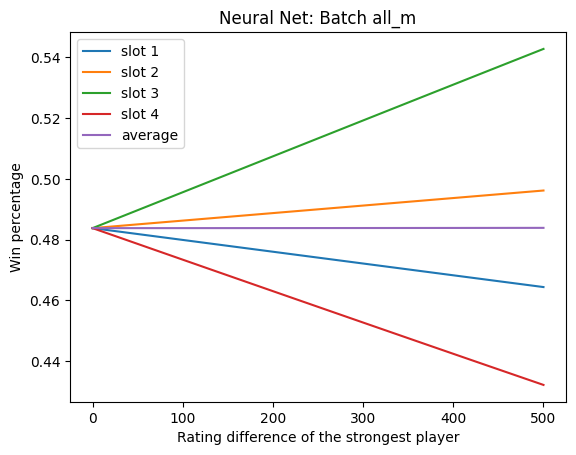

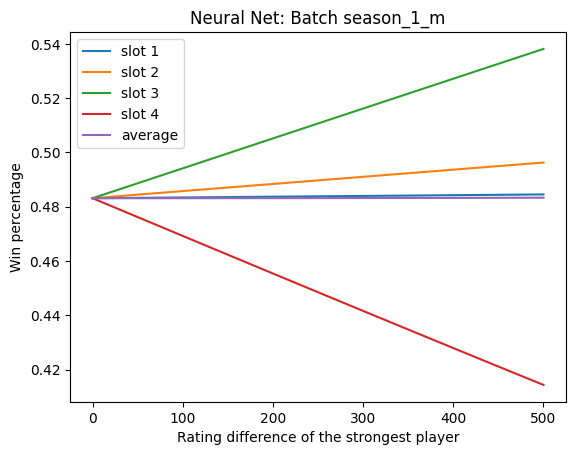

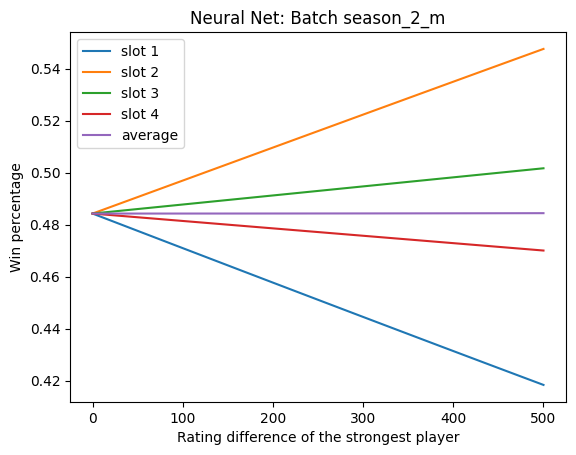

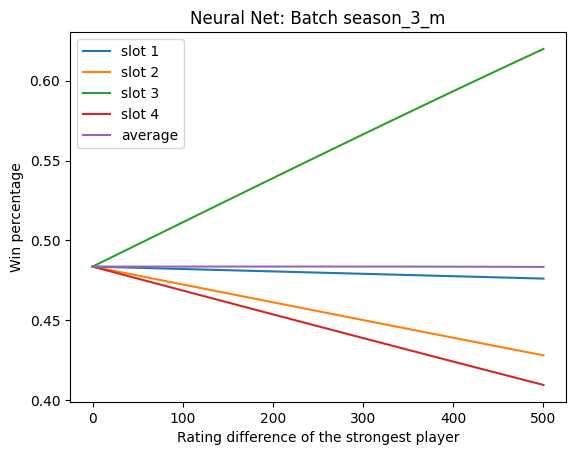

In [13]:
def graph_slots_MLP(batches, classifiers, func_builder, xlabel):
    x = np.linspace(0, 500, 100)
    for i, clf in enumerate(classifiers):

        fig, ax = plt.subplots()
        avg_y = np.zeros(len(x))
        for j in range(4):
            func = func_builder(j)
            plot_y = clf.predict_proba([func(v) for v in x])[:, 0]
            ax.plot(x, plot_y, label=f"slot {j+1}")
            avg_y += plot_y
        avg_y /= 4
        ax.plot(x, avg_y, label='average')

        ax.set(xlabel=xlabel, ylabel='Win percentage',
               title=f'Neural Net: Batch {batches[i]}')
        ax.legend()
        plt.show()

graph_slots_MLP(batches, classifiers, carry_player, 'Rating difference of the strongest player')

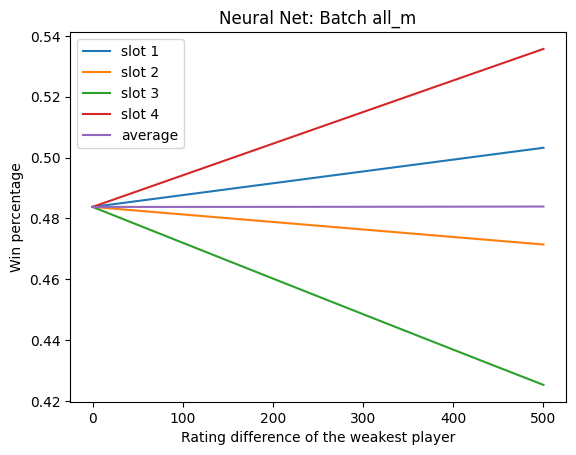

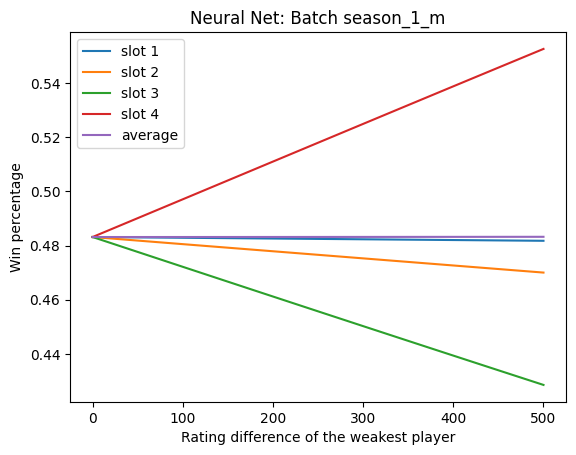

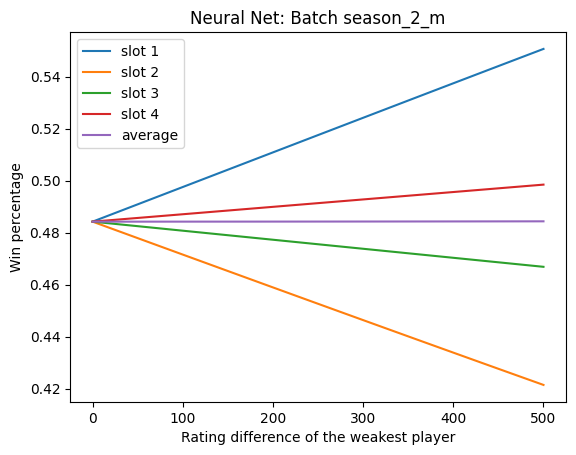

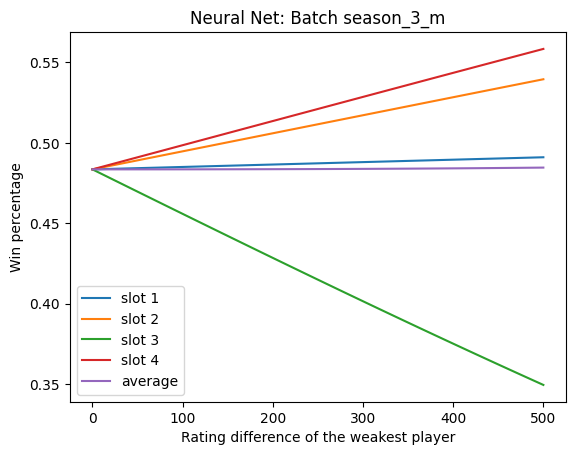

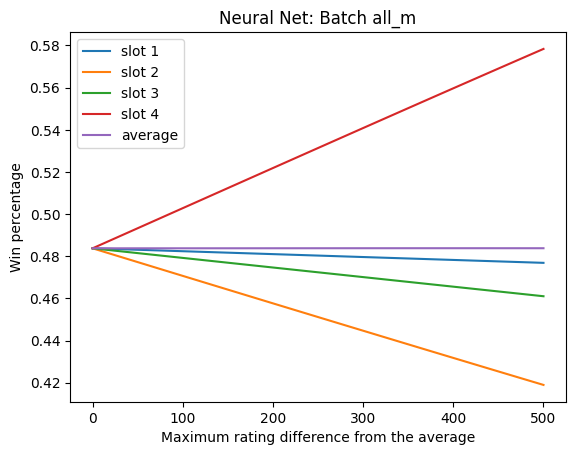

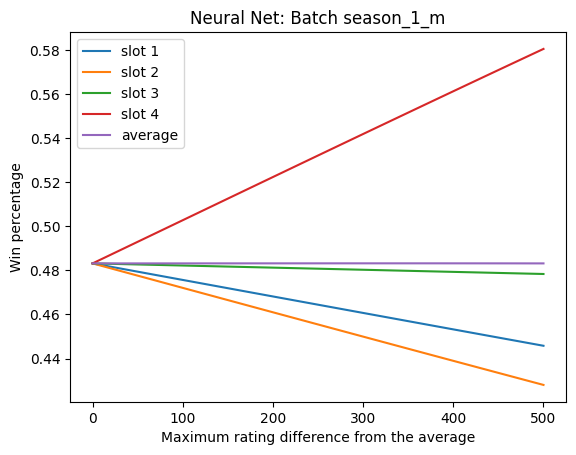

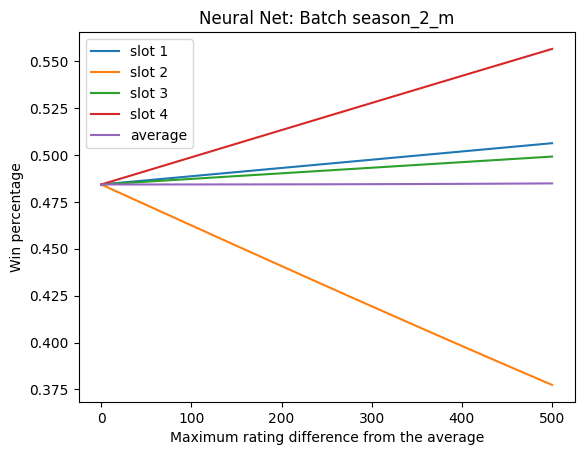

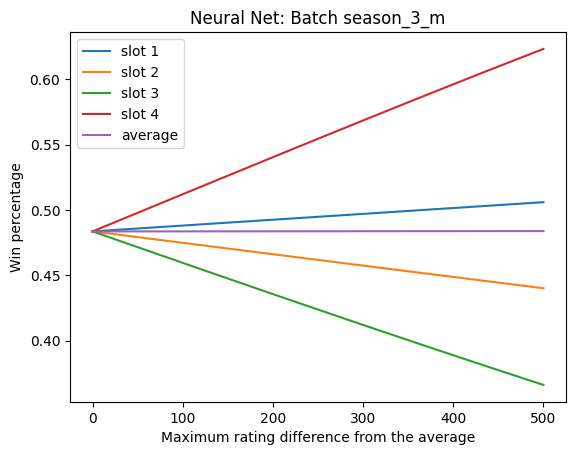

In [14]:
graph_slots_MLP(batches, classifiers, carried_player, 'Rating difference of the weakest player')
graph_slots_MLP(batches, classifiers, equal_spread, 'Maximum rating difference from the average')

## Results and Analysis

How well did your chosen ML algorithms fare on the domain? Compare and contrast the algorithms using metrics like loss, accuracy, training time, etc. Use graphs or tables to visualize these results. Why do you think the results came out the way they did?

## Conclusion

Use this space to conclude your final project. What are the main takeways from having done the project? What were some challenges you faced? What are the successes? If you had more time, what improvements or additional features would you add?